# What's driving logerror?

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use regression models to make logerror predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [13]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from importlib import reload


#import my personal modules created for this report
import wrangle as w
#import explore as e
#import model as m

## Acquire

* Data acquired from the Codeup mySQL server on November 30, 2022.
* It contained 52205 rows and 15 columns
* Each observation represents a single-family home where ```latitude```, ```longitude```, and ```yearbuilt``` are NOT NULL
* Each column represents a feature of those homes

In [3]:
#import unclean data from Codeup mySQL server
zillow_unclean = w.acquire_zillow_data()

In [4]:
zillow_unclean.shape

(52205, 15)

## Prepare

#### NULLs to 0
* For ```fireplace```, ```deck```, ```pool```, ```garage```, and ```hottub``` it was assumed NULL values indicated it did not exist on property so NULLs were converted to "0".

#### Created features
* ```county``` (names based on the fips code):  
    - 6037: LA
    - 6059: Orange 
    - 6111: Ventura 
* ```2017_age```
    - Column diplaying age of house in 2017 (2017-year_built)
    
#### Dropped rows:
* Rows containing null values in any column (< 1% dropped)

#### Other prep
* Split data into train, validate, and test (65/20/15)


***51843 rows before splitting*** 

In [5]:
#clean data
zillow = w.clean_zillow(zillow_unclean)

In [6]:
#split data
train, validate, test = w.split_data(zillow)

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**parcelid**| Definition| *int*|
| **bathroooms** | The number of bathrooms in the home. |*float*|
| **bedrooms** | The number of bedrooms in the home.|*int*|
|**sqft**| Square footage of the house| *int*|
|**year_built**| Year the house was built| *int*|
|**latitude**| | *float*|
|**longitude**| | *float*|
|**lotsizesquarefeet**| Square footage of the land where the property is located | *float*|
|**fireplace**| | *float*|
|**deck**| | *float*|
|**pool**| | *float*|
|**garage**| | *float*|
|**hottub**| | *float*|
|**county**| Name of the county where the house is located| *string*|
|**2017_age**| Age of the house in 2017 (when the data was collected| *int*|
|**Target variable**
|**logerror**| 𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒) | *float* |

### A look at the data

In [9]:
#show the first few rows of the train data
train.head()

parcelid  logerror  bathrooms  bedrooms  sqft       latitude  \
46729  11669351     0.037      4.000         4  3470 34,045,821.000   
47582  13844703    -0.104      1.000         3   999 33,728,543.000   
32610  14110023     0.043      3.000         5  1803 33,825,991.000   
22180  11703748    -0.003      1.000         2  1586 34,001,625.000   
28282  13899266     0.166      1.000         2   902 33,427,590.000   

             longitude  lotsizesquarefeet  fireplace  deck  pool  garage  \
46729 -118,517,058.000               7148          0     0     0       0   
47582 -117,879,618.000               6716          0     0     1       1   
32610 -118,045,155.000               6203          0     0     0       1   
22180 -118,304,436.000               5867          0     0     0       0   
28282 -117,617,406.000               4600          0     0     0       1   

       hottub  county  2017_age  
46729       0      LA        12  
47582       1  Orange        67  
32610       1  Orange        53  
22180       0      LA       105  
28282       1  Orange        57

## Explore

### 1. What is the distribution of logerror based on county?

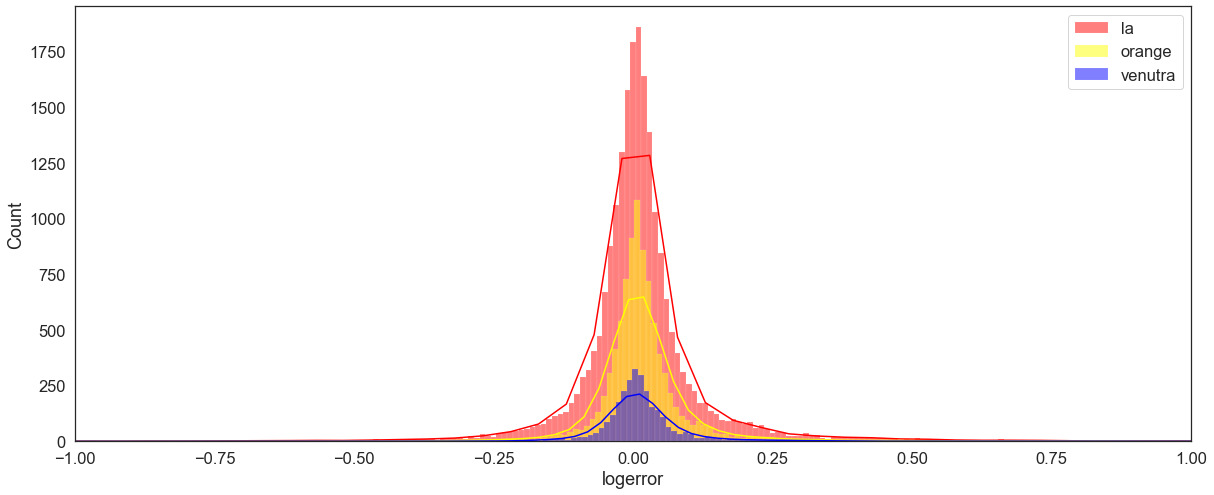

In [16]:
#set font size
sns.set(font_scale=1.5)
#set plot style
sns.set_style('white')
fig, ax = plt.subplots(1,1, figsize=(20,8))

sns.histplot(train[train.county=='LA'].logerror, kde=True, ax=ax, binwidth=.01, color='red', label='la')
sns.histplot(train[train.county=='Orange'].logerror, kde=True, ax=ax, binwidth=.01,color ='yellow', label='orange')
sns.histplot(train[train.county=='Ventura'].logerror, kde=True, ax=ax, binwidth=.01, color='blue', label='venutra')
ax.set_xlim(-1,1)
ax.legend()
plt.show()

### 2. What is the relationship between sqft and logerror? 

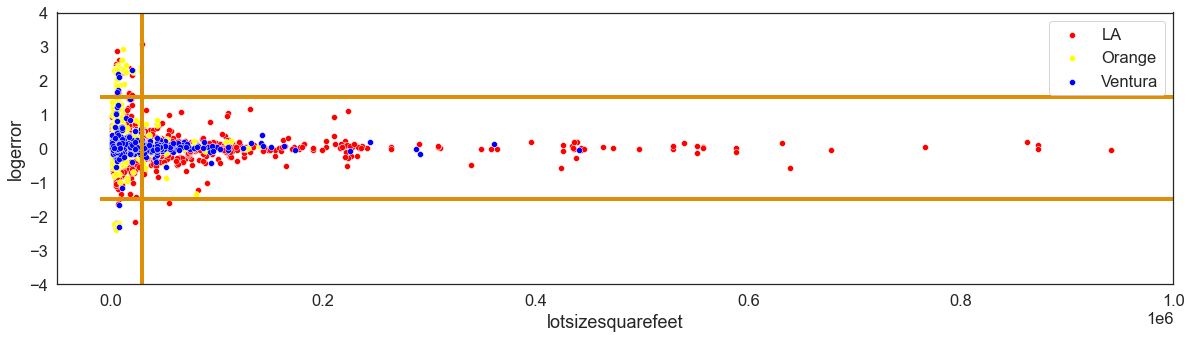

In [15]:
#set font size
sns.set(font_scale=1.5)
#set plot style
sns.set_style('white')

#make plot
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.scatterplot('lotsizesquarefeet', 'logerror', label='LA', data=train[train.county=='LA'], color = "red")
sns.scatterplot('lotsizesquarefeet', 'logerror', label='Orange', data=train[train.county=='Orange'], color="yellow")
sns.scatterplot('lotsizesquarefeet', 'logerror', label='Ventura', data=train[train.county=='Ventura'], color="blue")
ax.vlines(30000, -4, 4, color="#de8f05", linewidth=4)
ax.set_ylim(-4,4)
ax.hlines(1.5, -10000, 1000000, color="#de8f05", linewidth=4)
ax.hlines(-1.5, -10000, 1000000, color="#de8f05", linewidth=4)
ax.set_xlim(-50000,1000000)
ax.set_ylabel("logerror")
ax.legend()
plt.show()

**It looks like there is a linear correlation between square feet and logerror.** 

***Also looks like the original model did a good job at predicting larger homes.***

**Set Hypothesis**

$H_0$ = There is no linear correlation between sqft and logerror 

$H_a$ = There is a linear correlation between sqft and logerror 

In [10]:
 #run spearman test to see if there is any linear correlation
corr, p = stats.spearmanr(train.sqft, train.logerror)

#print results
print(f"Correlation Coefficient: {corr:.2}\np-value: {p:.4}")

Correlation Coefficient: 0.079
p-value: 9.264e-48


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between square footage and logerror.** 

In [8]:
train_scale, validate_scale, test_scale =w.scale_zillow(train, validate, test, 'logerror')

In [87]:
train_scale

parcelid  logerror  bathrooms  bedrooms  sqft  latitude  longitude  \
46729     0.006     0.037      0.308     0.400 0.153     0.477      0.499   
47582     0.021    -0.104      0.077     0.300 0.040     0.262      0.831   
32610     0.022     0.043      0.231     0.500 0.077     0.328      0.745   
22180     0.007    -0.003      0.077     0.200 0.067     0.447      0.610   
28282     0.021     0.166      0.077     0.200 0.036     0.059      0.967   
...         ...       ...        ...       ...   ...       ...        ...   
30659     0.024     0.012      0.192     0.300 0.126     0.199      0.926   
15594     0.014    -0.033      0.077     0.300 0.038     0.512      0.810   
28450     0.003    -0.074      0.077     0.400 0.059     0.869      0.686   
47657     0.023     0.089      0.115     0.300 0.039     0.207      0.808   
45805     0.014     0.301      0.231     0.500 0.120     0.418      0.772   

       lotsizesquarefeet  fireplace  deck  pool  garage  hottub  county  \
46729              0.001      0.000 0.000 0.000   0.000   0.000      LA   
47582              0.001      0.000 0.000 1.000   1.000   1.000  Orange   
32610              0.001      0.000 0.000 0.000   1.000   1.000  Orange   
22180              0.001      0.000 0.000 0.000   0.000   0.000      LA   
28282              0.001      0.000 0.000 0.000   1.000   1.000  Orange   
...                  ...        ...   ...   ...     ...     ...     ...   
30659              0.001      0.000 0.000 0.000   1.000   1.000  Orange   
15594              0.001      0.000 0.000 0.000   0.000   0.000      LA   
28450              0.008      0.000 0.000 0.000   0.000   0.000      LA   
47657              0.001      0.000 0.000 0.000   1.000   1.000  Orange   
45805              0.003      0.000 0.000 1.000   0.000   0.000      LA   

       2017_age  sqft_lotsize_feature  sqft_lotsize_cluster  \
46729     0.080                     1                     2   
47582     0.478                     0                     0   
32610     0.377                     5                     4   
22180     0.754                     5                     0   
28282     0.406                     0                     0   
...         ...                   ...                   ...   
30659     0.261                     4                     2   
15594     0.449                     0                     0   
28450     0.471                     0                     0   
47657     0.442                     0                     0   
45805     0.362                     4                     4   

       special_features_cluster  
46729                         1  
47582                         2  
32610                         2  
22180                         1  
28282                         2  
...                         ...  
30659                         2  
15594                         1  
28450                         1  
47657                         2  
45805                         1  

[33697 rows x 18 columns]

## 3. ??????

## 4. ???????

**It looks like there is a linear correlation between ?????? and logerror**

**Set Hypothesis**

$H_0$ = There is no linear correlation between ?????? and logerror 

$H_a$ = There is a linear correlation between ?????? and logerror

In [13]:
#run spearmanr test and show results
#e.age_spearmanr(train)

**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between 2017_age and home value.** 

### Exploration Summary
* ```square_feet``` has the highest correlation coefficient so I will use it in my model.
* ```bed_bath_ratio```, ```2017_age```, and ```county``` all show a relationship with home value so I will also take them to my model.

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|**size_location_cluster**| |
|**bath_bed_ratio**| From our Spearman's test we saw that the correlation coefficient is 0.32 between ```bath_bed_ratio``` and ```home_value```|
|**2017_age**| From our Spearman's test we saw that the correlation coefficient is 0.27 between ```2017_age``` and ```home_value```|
|**county**| From our ANOVA test we see that there is a difference between the home values in each county|

### Features I'm not moving on with

| Feature | Reason 
|:--------|:-----------
|**parcelid**| id number that is not needed in the model
| **bathroooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
| **bedrooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
|**year_built**| Represented in the ```2017_age``` so it would be redundant.

## sqft_lotsize_cluster

In [30]:
sqft_lotsize_cluster = train_scale[['sqft', 'lotsizesquarefeet']]

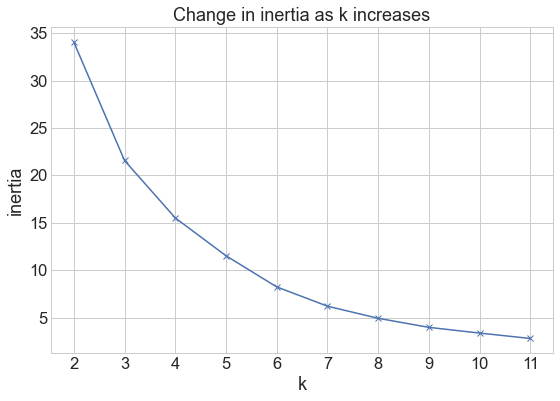

In [31]:
from sklearn.cluster import KMeans
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(sqft_lotsize_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [128]:
#Fit a new model to my scaled data
kmeans_scale = KMeans(n_clusters=5)

kmeans_scale.fit(sqft_lotsize_cluster)

train['sqft_lotsize_cluster'] = kmeans_scale.predict(sqft_lotsize_feature)

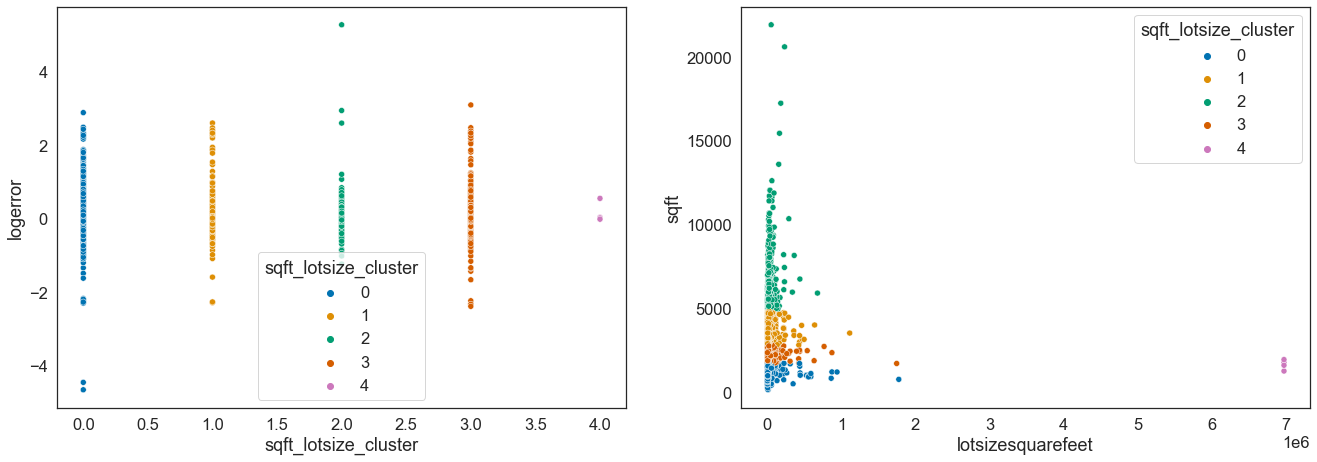

In [130]:
sns.set(font_scale=1.5)
sns.set_style('white')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
fig.tight_layout(pad=4.0)

sns.scatterplot(ax=ax1, y='logerror', x='sqft_lotsize_cluster',hue='sqft_lotsize_cluster',
                palette='colorblind', data=train)
sns.scatterplot(ax=ax2, y='sqft', x='lotsizesquarefeet', hue='sqft_lotsize_cluster',
                palette='colorblind', data=train)

plt.show()

## latitude/longitude house size

In [113]:
location_size = train_scale[['latitude', 'longitude', 'sqft']]

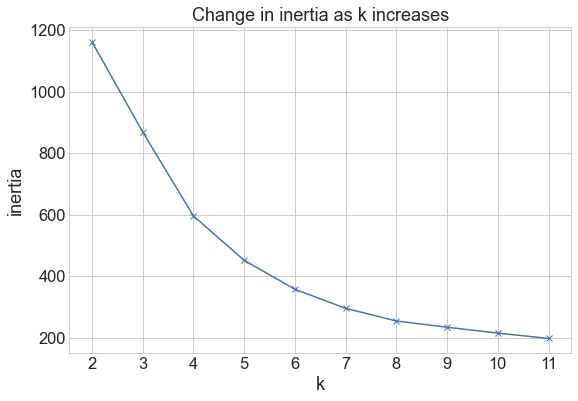

In [114]:
from sklearn.cluster import KMeans
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(location_size).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [131]:
#Fit a new model to my scaled data
kmeans_scale = KMeans(n_clusters=6)

kmeans_scale.fit(location_size)

train['location_size'] = kmeans_scale.predict(location_size)

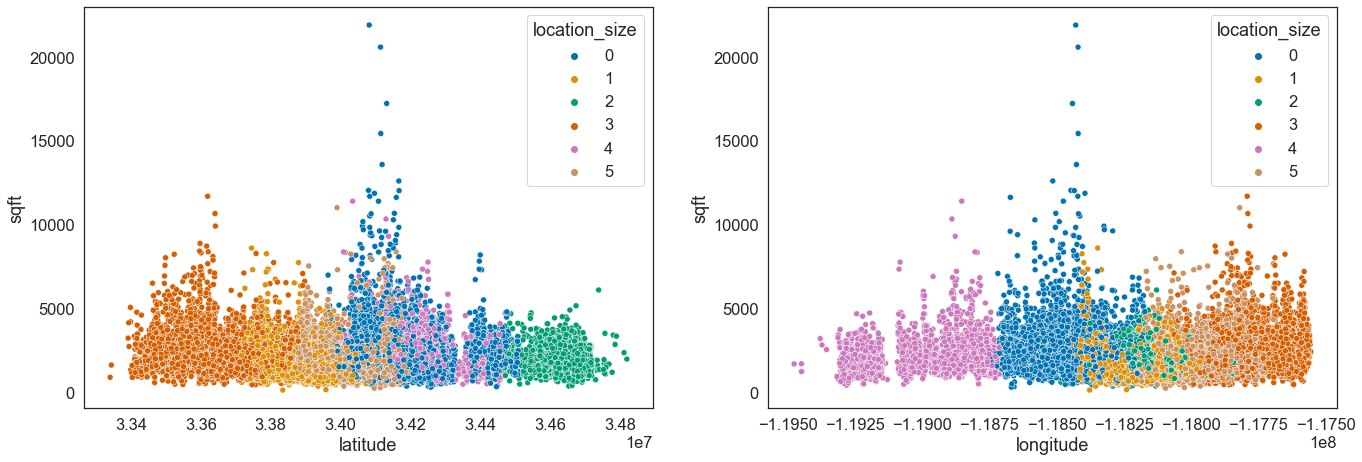

In [132]:
sns.set(font_scale=1.5)
sns.set_style('white')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
fig.tight_layout(pad=4.0)
sns.scatterplot(ax=ax1, y='sqft', x='latitude', hue='location_size',
                palette='colorblind', data=train)
sns.scatterplot(ax=ax2, y='sqft', x='longitude', hue='location_size',
                palette='colorblind', data=train)
plt.show()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

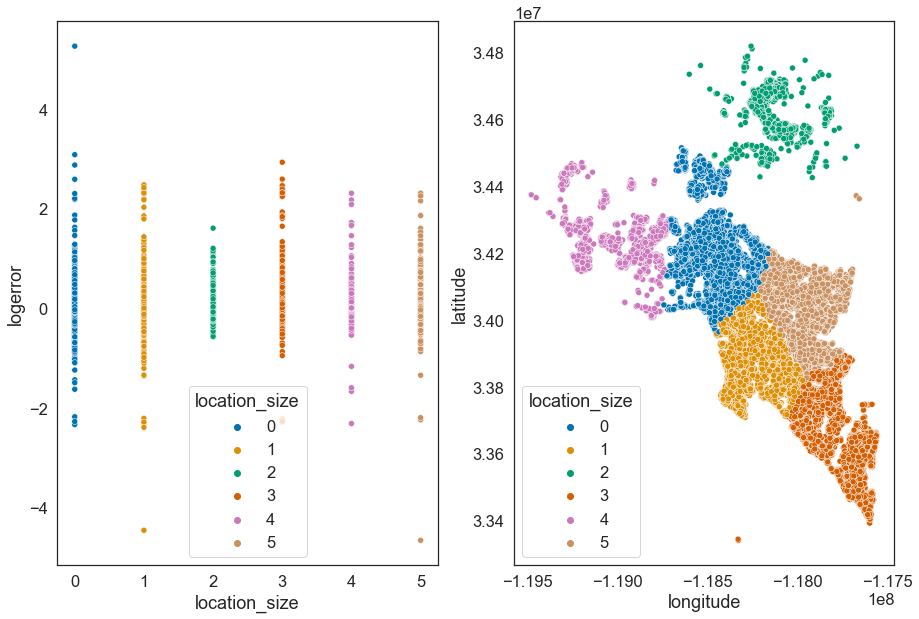

In [133]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
sns.scatterplot(ax =ax1, y='logerror', x='location_size',
                palette='colorblind', data=train, hue='location_size')
sns.scatterplot(ax=ax2, data =train, x='longitude', palette='colorblind', y= 'latitude', hue='location_size')

## size_location_cluster

In [18]:
size_location_cluster = train_scale[['sqft', 'lotsizesquarefeet', 'latitude', 'longitude']]

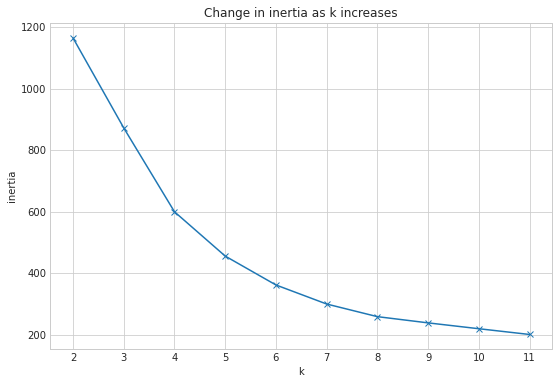

In [19]:
from sklearn.cluster import KMeans
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(size_location_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [20]:
#Fit a new model to my scaled data
kmeans_scale = KMeans(n_clusters=6)

kmeans_scale.fit(size_location_cluster)

train['size_location_cluster'] = kmeans_scale.predict(size_location_cluster)

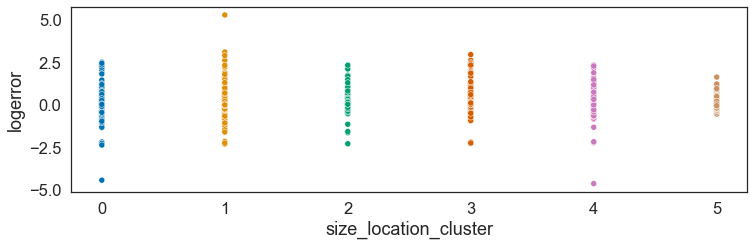

In [29]:
sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(1,1, figsize=(12,5))
fig.tight_layout(pad=4.0)

sns.scatterplot(y='logerror', x='size_location_cluster',hue='size_location_cluster',
                palette='colorblind', data=train)
ax.get_legend().remove()
plt.show()

In [35]:
cluster0 = train[train['size_location_cluster'] ==0].logerror
cluster1 = train[train['size_location_cluster'] ==1].logerror
cluster2 = train[train['size_location_cluster'] ==2].logerror
cluster3 = train[train['size_location_cluster'] ==3].logerror
cluster4 = train[train['size_location_cluster'] ==4].logerror
cluster5 = train[train['size_location_cluster'] ==5].logerror

In [36]:
stats.kruskal(cluster0,cluster1,cluster2,cluster3,cluster4,cluster5)

KruskalResult(statistic=71.33664699177382, pvalue=5.399634496862122e-14)

## special_features_cluster

In [9]:
special_features1 = ['pool','deck','garage','hottub', 'fireplace']

In [11]:
special_features_cluster1 = train_scale[['pool','deck','garage','hottub', 'fireplace']]

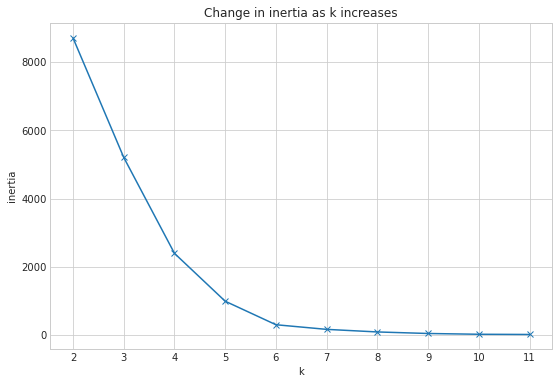

In [14]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(special_features_cluster1).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

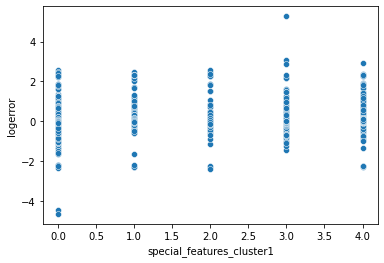

In [17]:
#Fit a new model to my scaled data
kmeans_scale = KMeans(n_clusters=5)

kmeans_scale.fit(special_features_cluster1)

train_scale['special_features_cluster1'] = kmeans_scale.predict(special_features_cluster1)
sns.scatterplot(y='logerror', x='special_features_cluster1',
        palette='colorblind', data=train_scale)
plt.show()

In [ ]:
special_features = ['pool','deck','garage','hottub', 'fireplace']

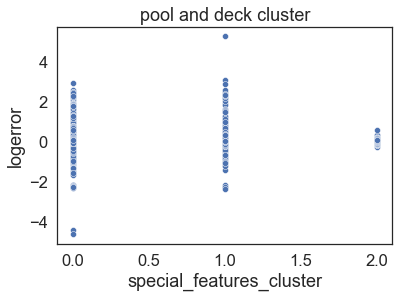

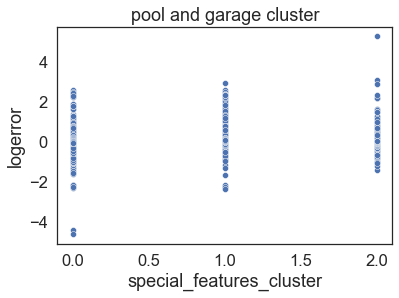

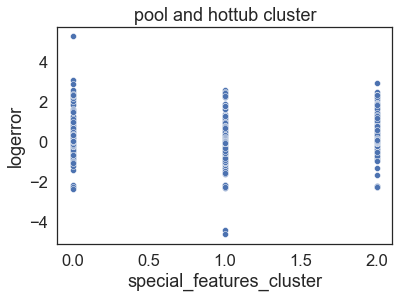

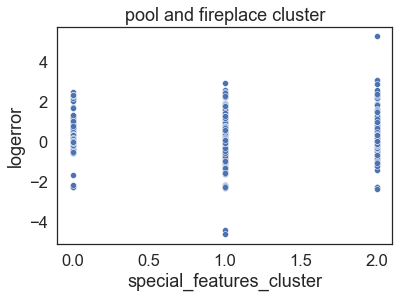

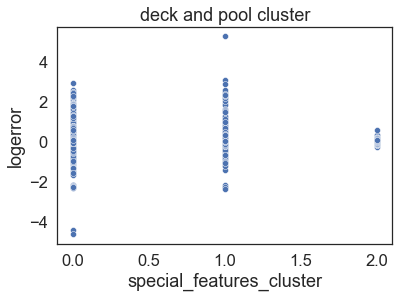

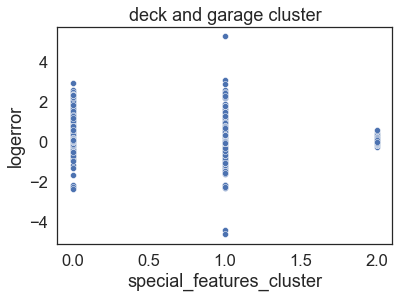

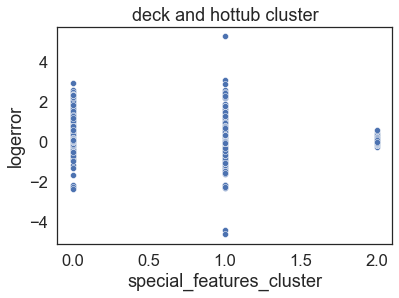

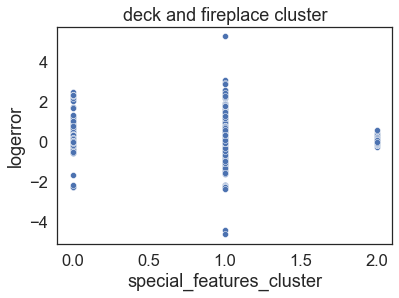

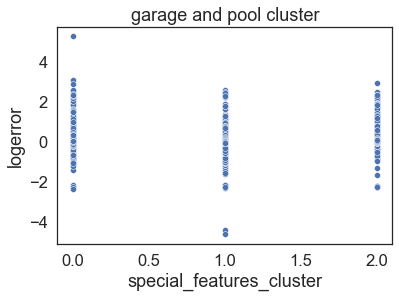

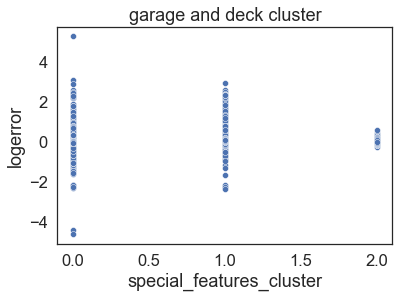

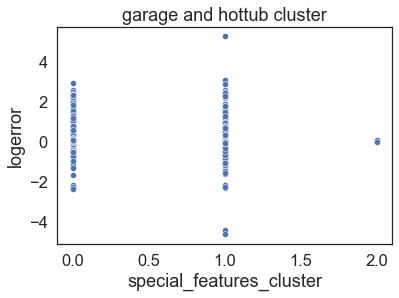

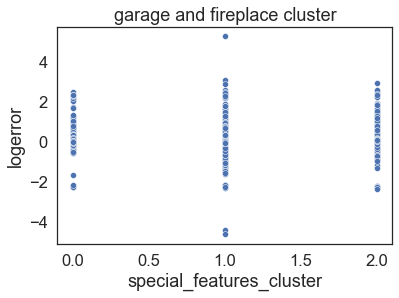

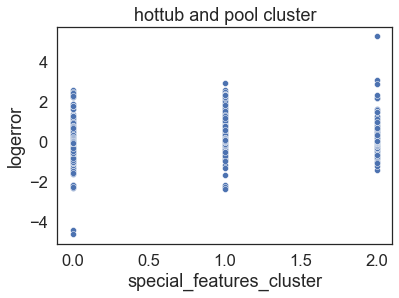

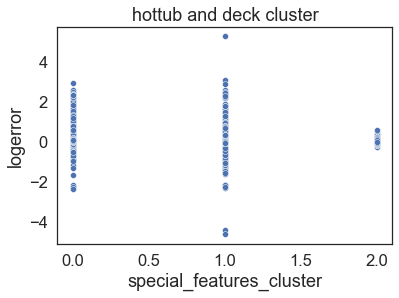

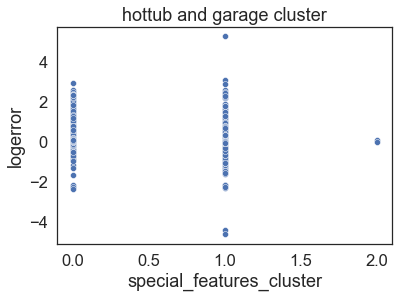

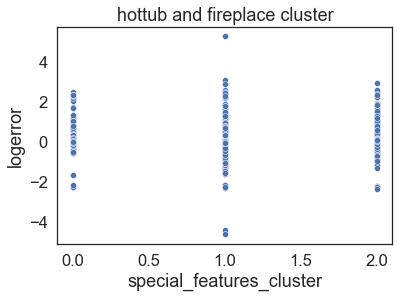

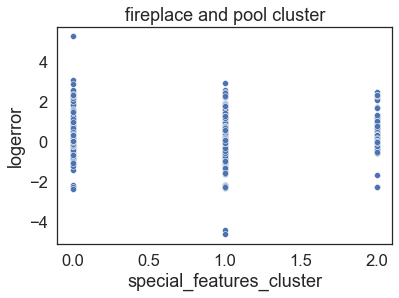

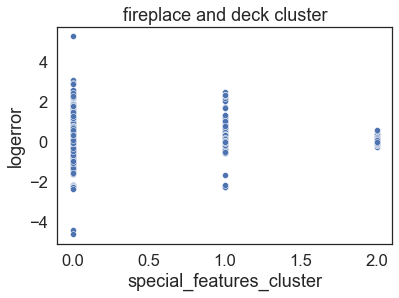

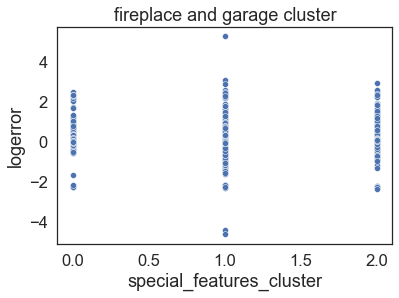

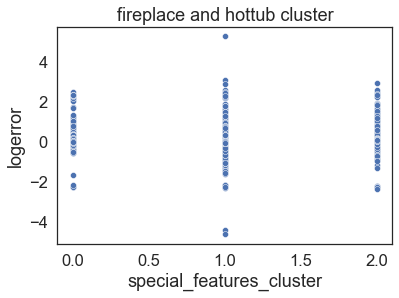

In [137]:
from sklearn.cluster import KMeans
for feature in special_features:
    for feature2 in special_features:
        if feature != feature2: 
            special_features_cluster = train_scale[[feature, feature2]]

            #Fit a new model to my scaled data
            kmeans_scale = KMeans(n_clusters=3)

            kmeans_scale.fit(special_features_cluster)

            train_scale['special_features_cluster'] = kmeans_scale.predict(special_features_cluster)
            plt.title(f'{feature} and {feature2} cluster')
            sns.scatterplot(y='logerror', x='special_features_cluster',
                    palette='colorblind', data=train_scale)
            plt.show()

## bed_bath_cluster

In [30]:
bed_bath_cluster = train_scale[['bathrooms','bedrooms']]

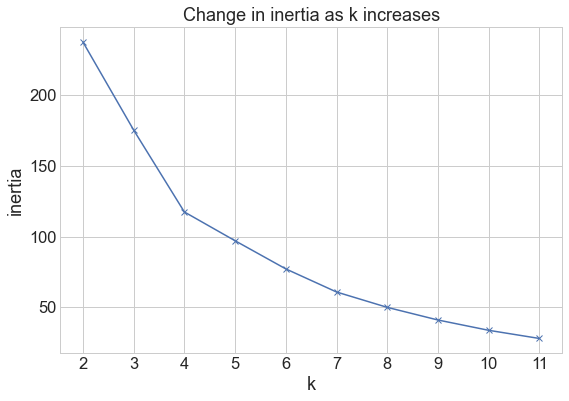

In [31]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(bed_bath_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

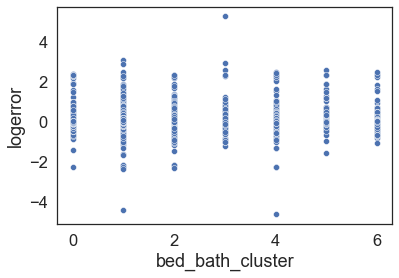

In [32]:
#Fit a new model to my scaled data
kmeans_scale = KMeans(n_clusters=7)

kmeans_scale.fit(bed_bath_cluster)

train_scale['bed_bath_cluster'] = kmeans_scale.predict(bed_bath_cluster)
sns.scatterplot(y='logerror', x='bed_bath_cluster',
        palette='colorblind', data=train_scale)
plt.show()

## cluster options

In [107]:
all_features = list(train_scale.columns)
all_features.remove('logerror')
all_features.remove('parcelid')
all_features.remove('county')
cluster_test = train_scale.copy()

In [108]:
all_features

['bathrooms',
 'bedrooms',
 'sqft',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'fireplace',
 'deck',
 'pool',
 'garage',
 'hottub',
 '2017_age']

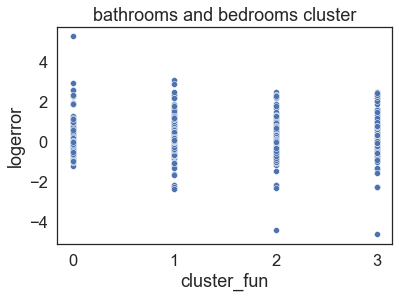

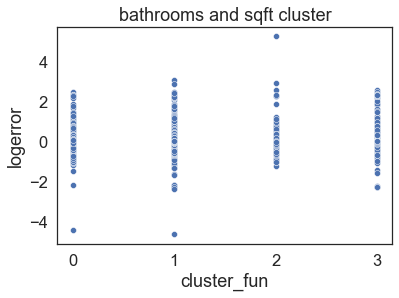

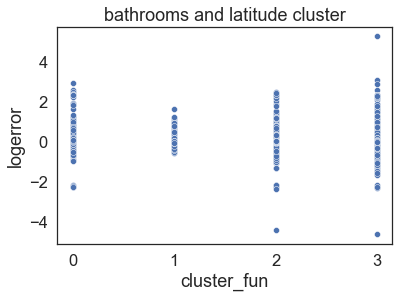

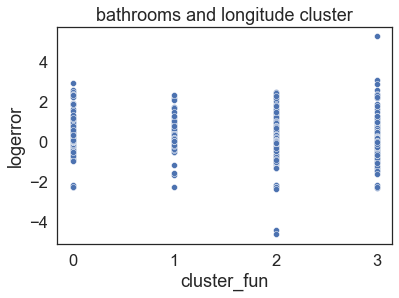

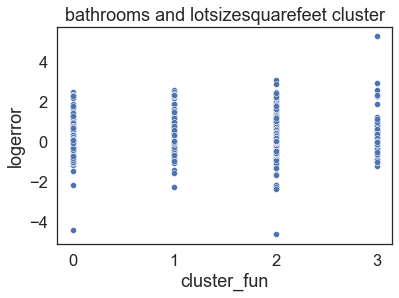

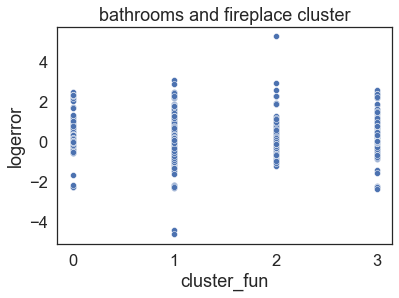

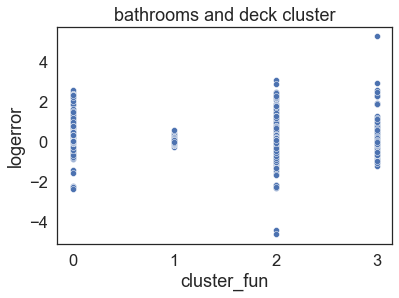

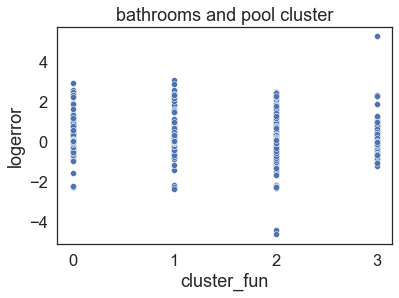

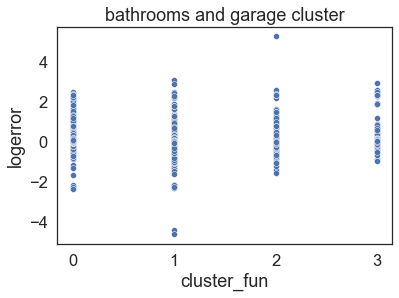

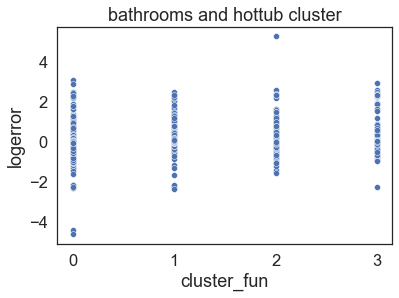

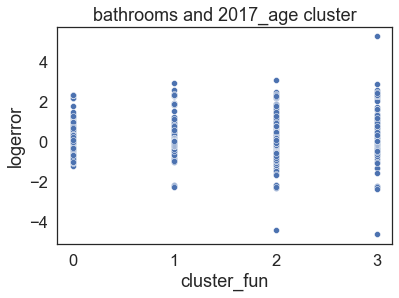

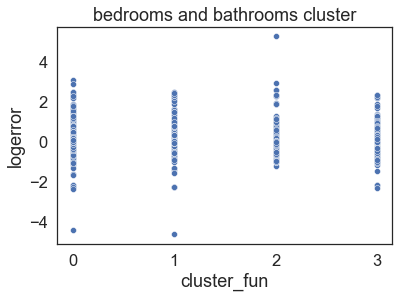

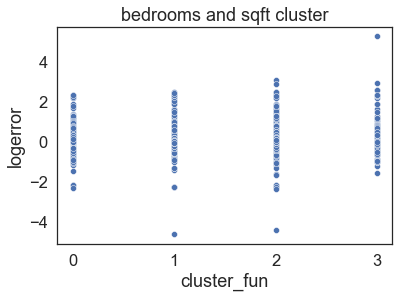

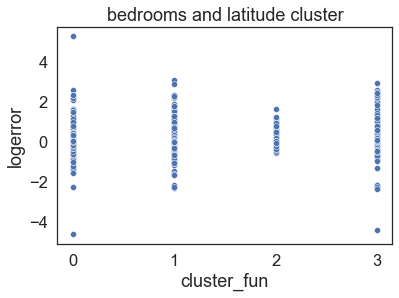

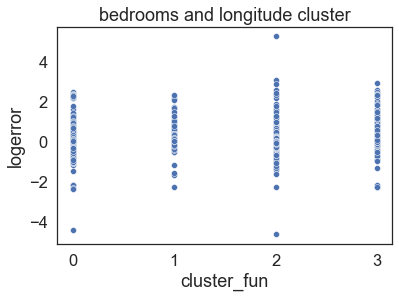

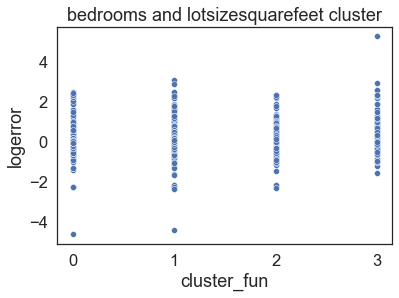

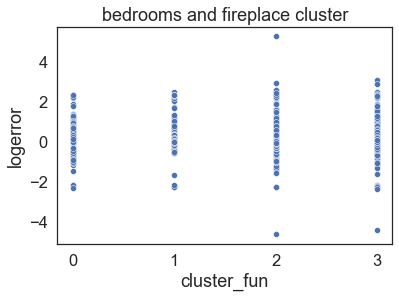

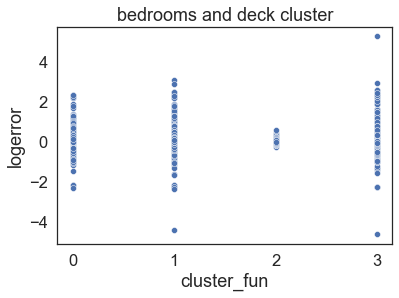

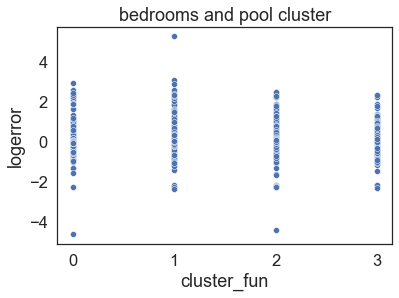

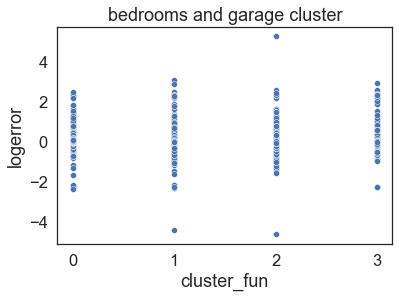

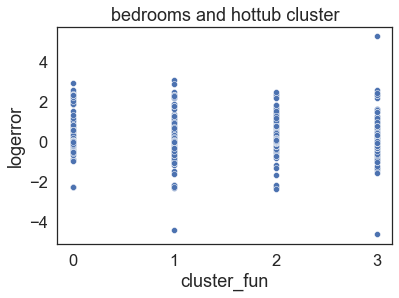

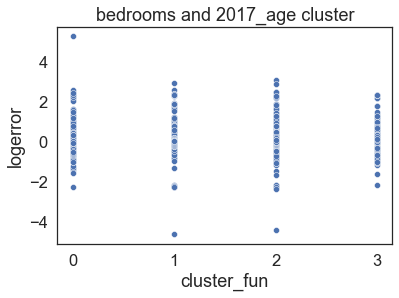

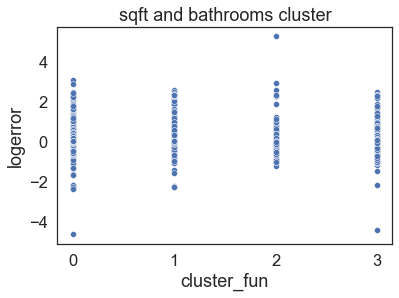

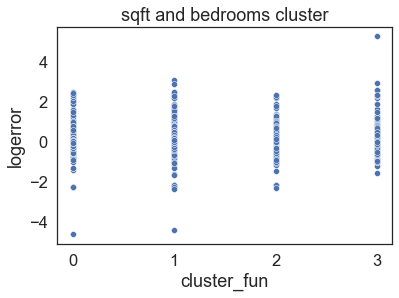

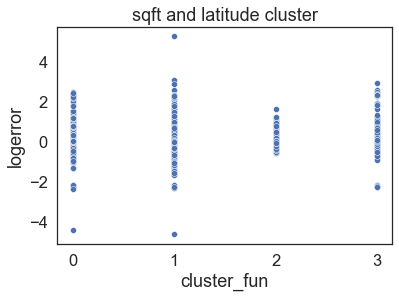

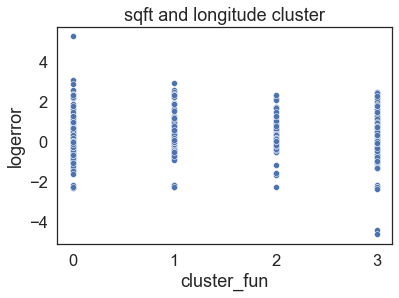

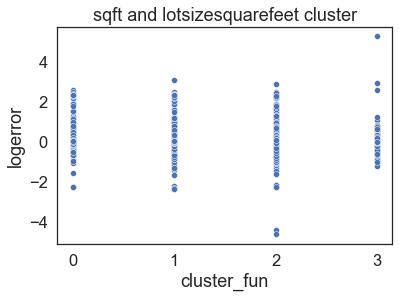

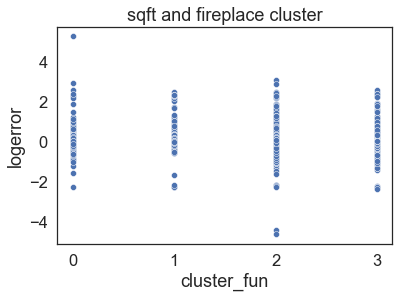

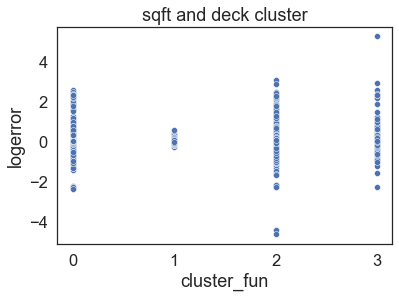

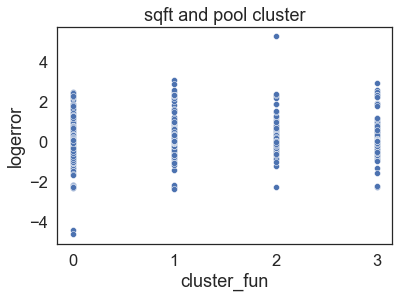

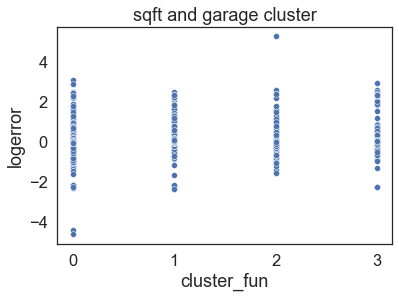

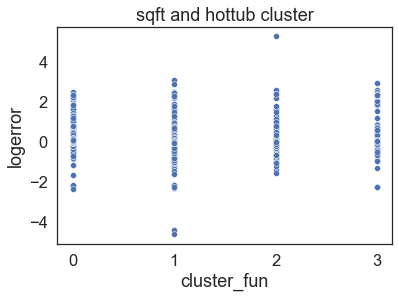

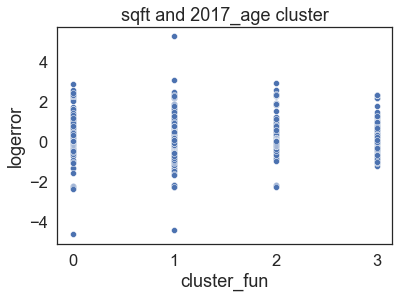

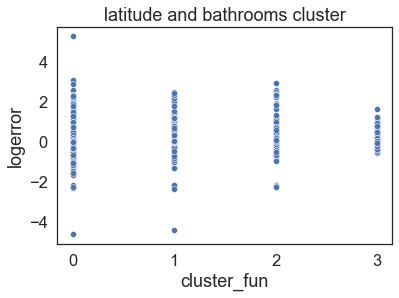

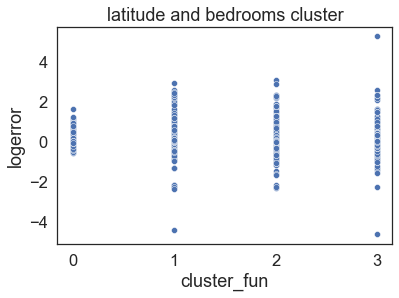

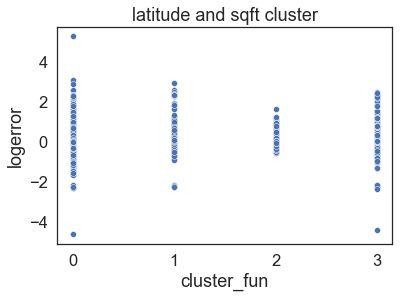

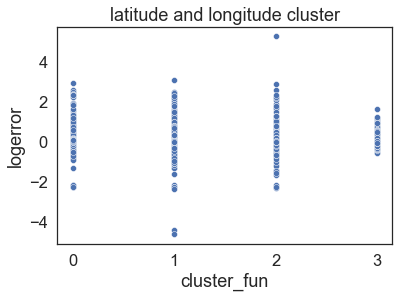

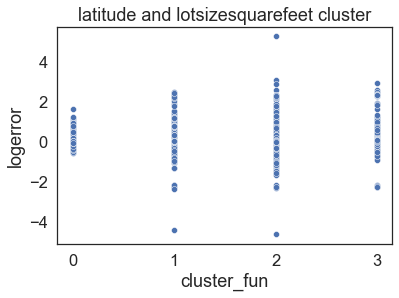

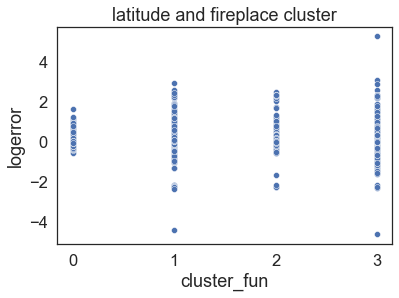

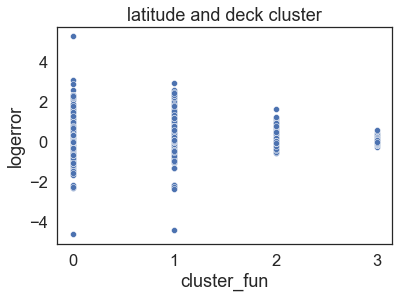

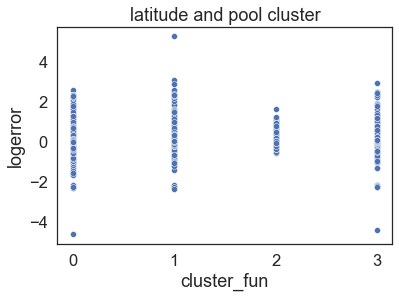

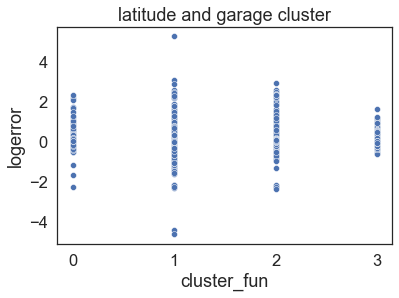

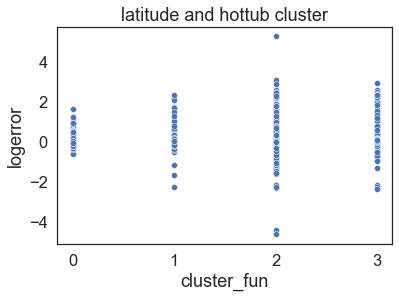

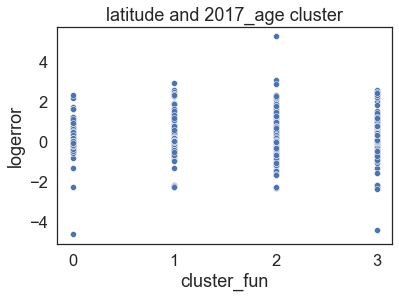

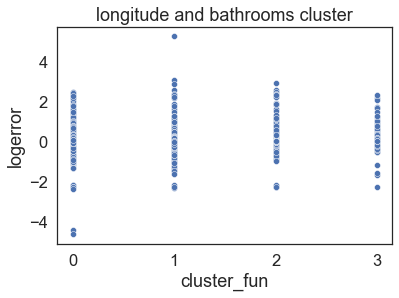

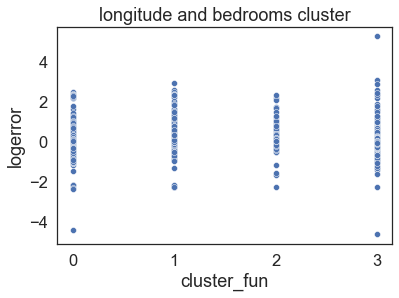

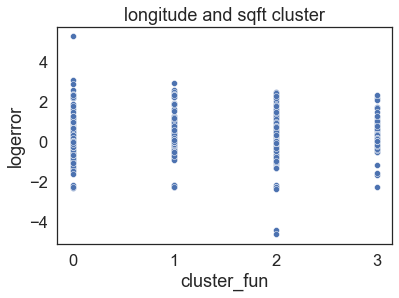

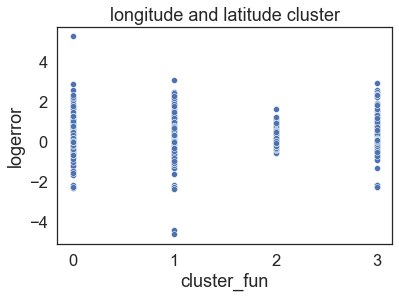

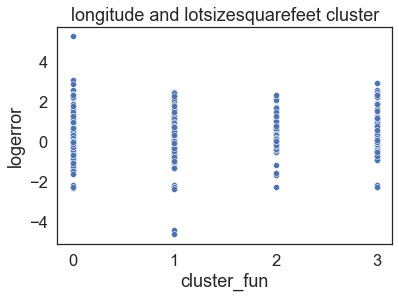

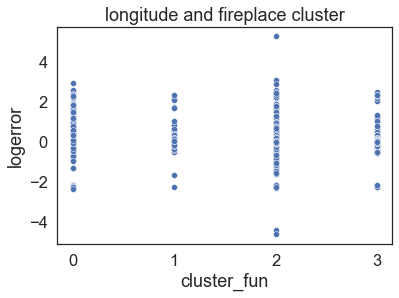

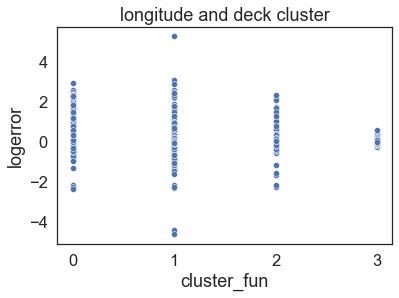

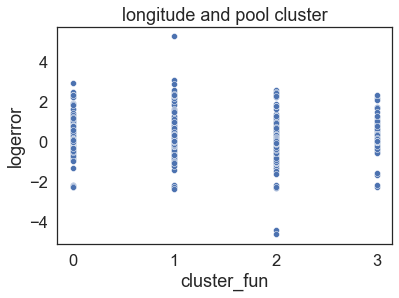

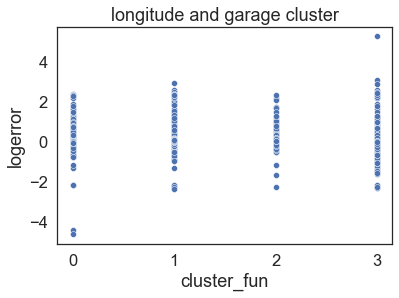

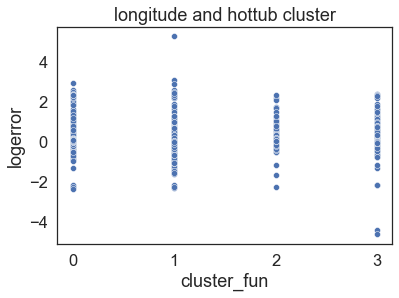

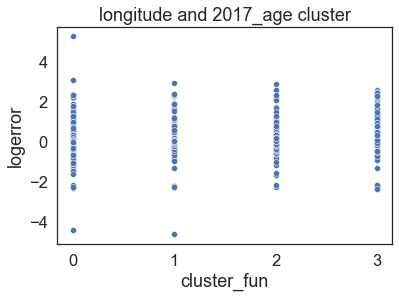

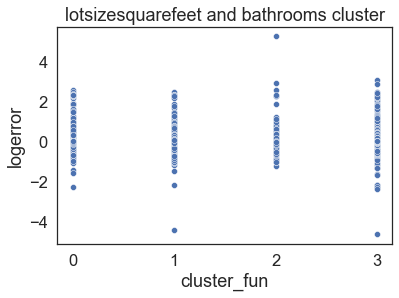

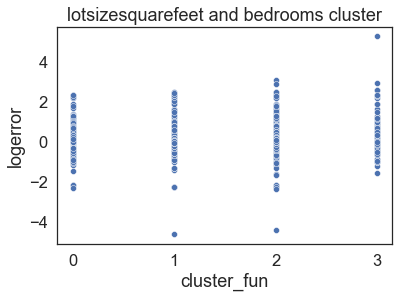

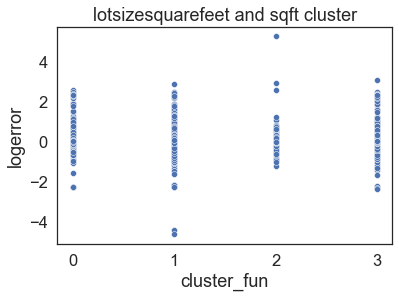

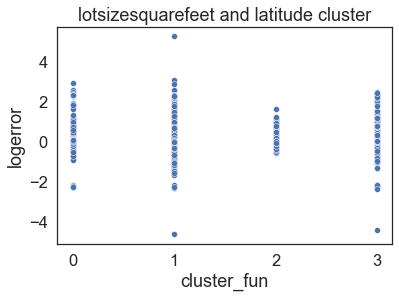

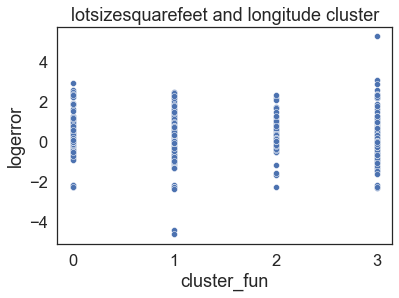

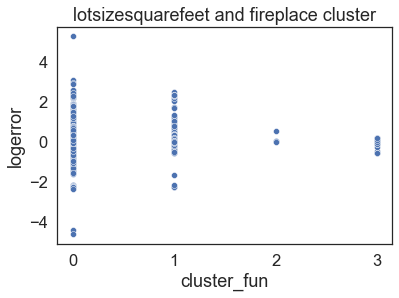

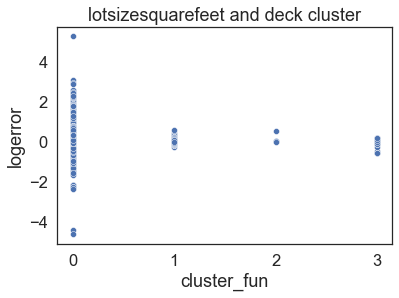

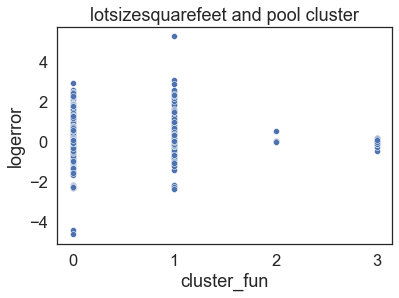

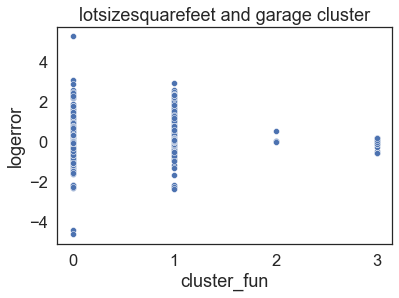

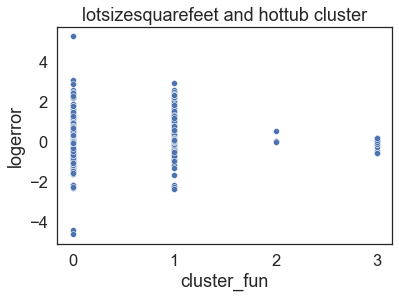

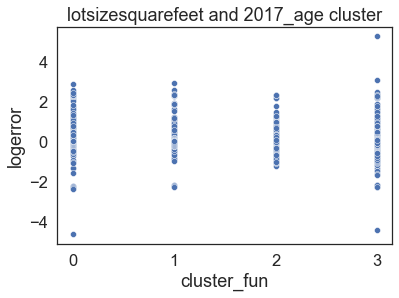

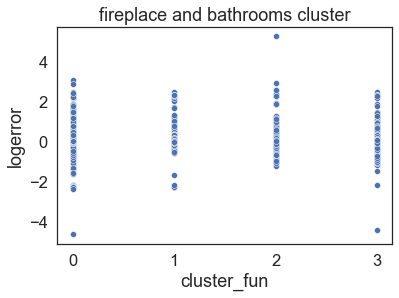

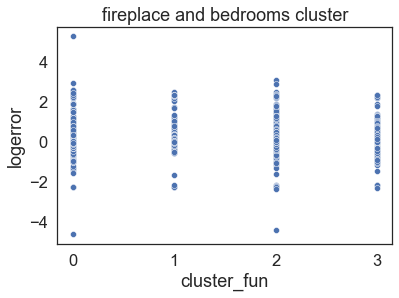

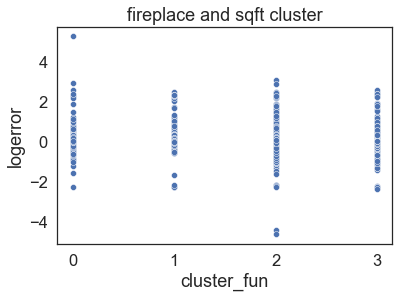

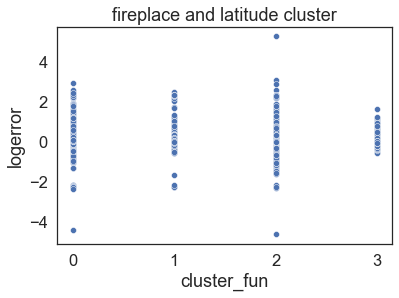

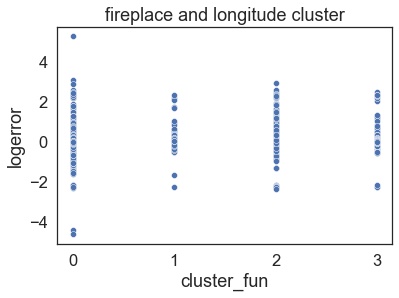

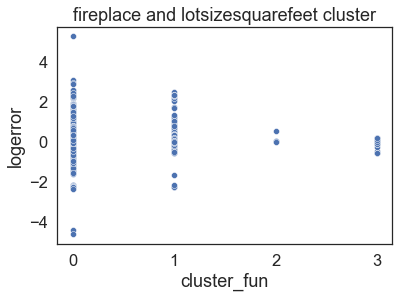

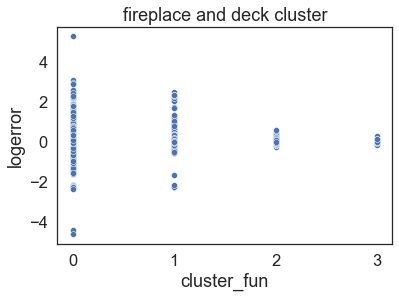

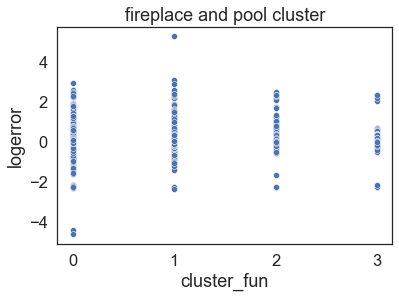

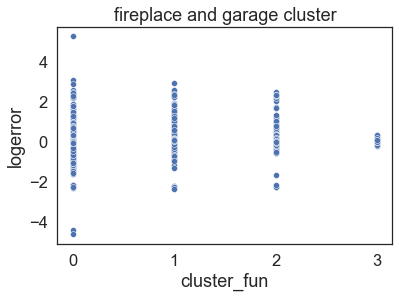

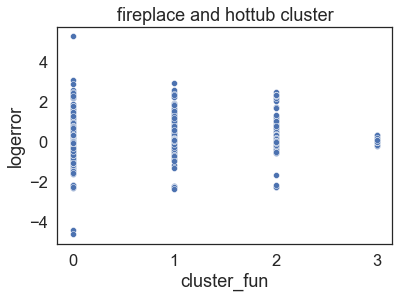

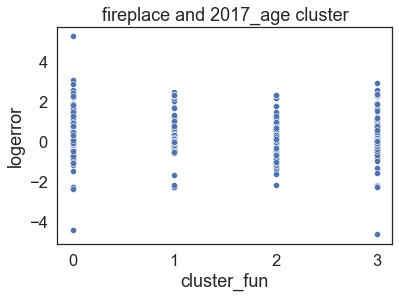

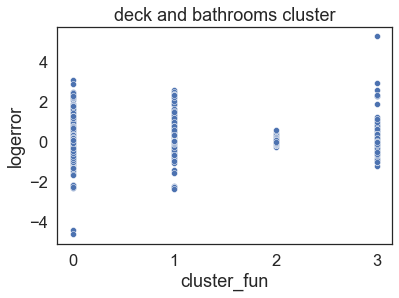

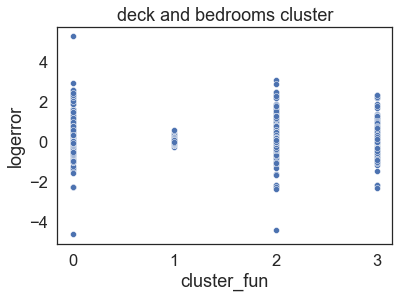

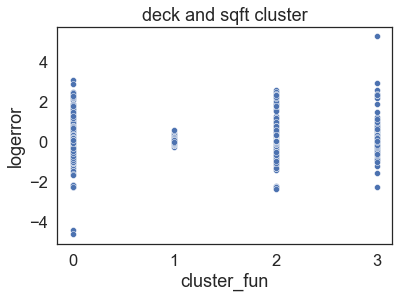

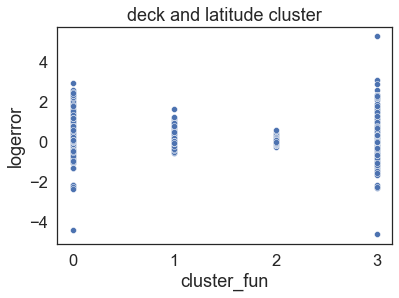

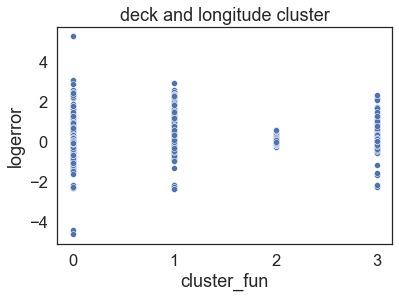

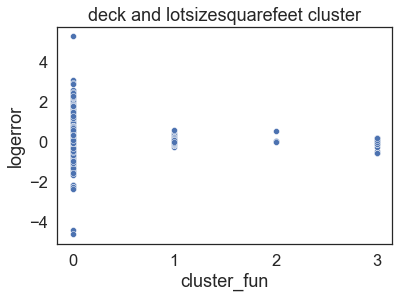

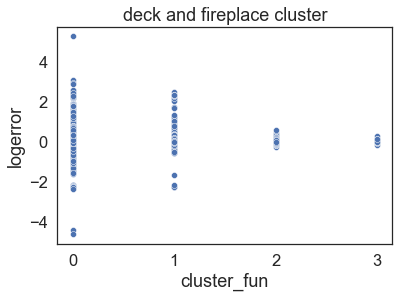

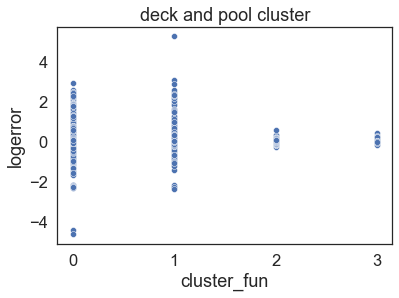

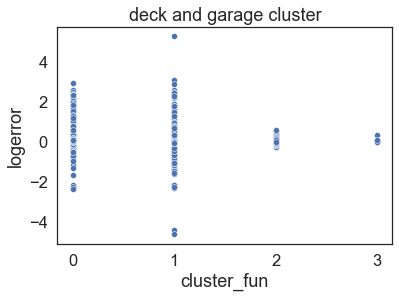

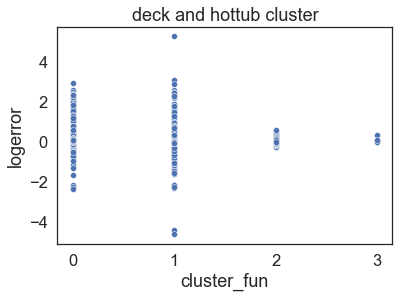

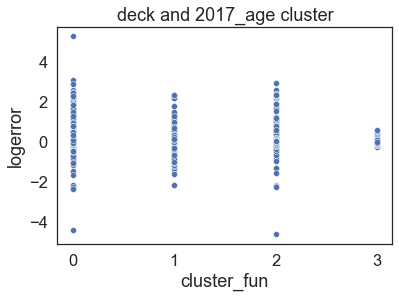

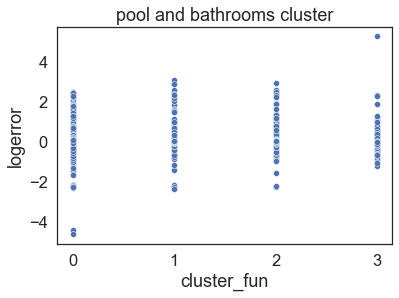

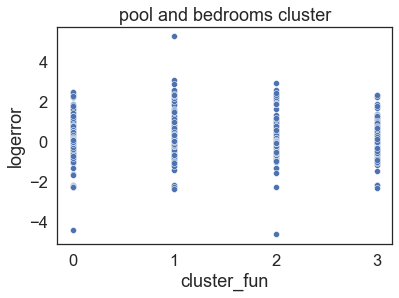

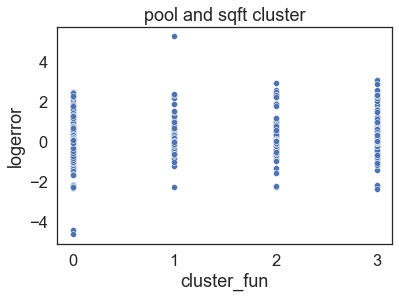

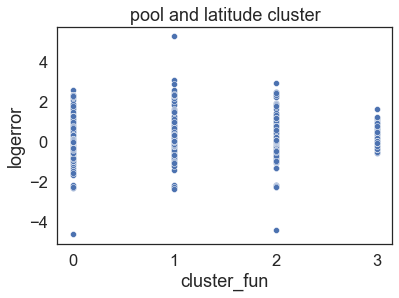

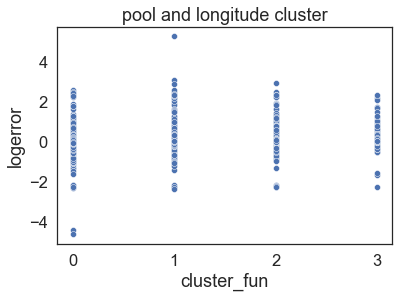

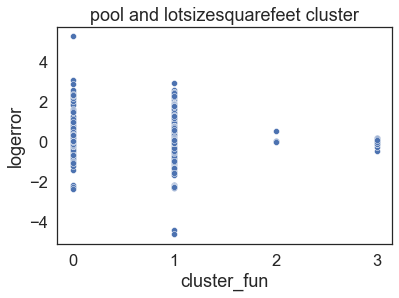

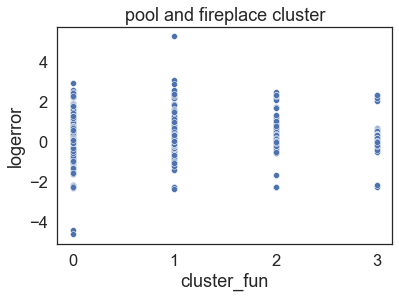

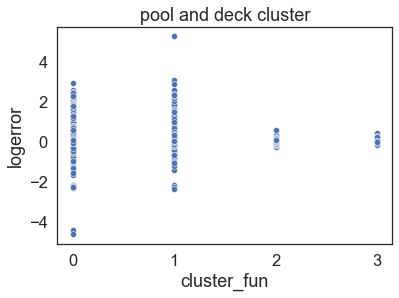

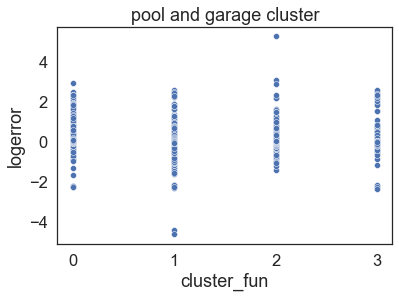

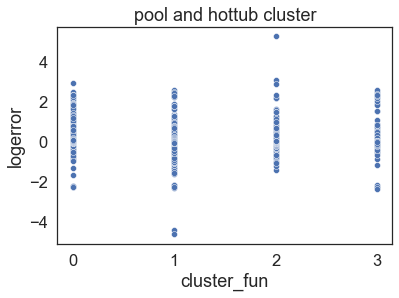

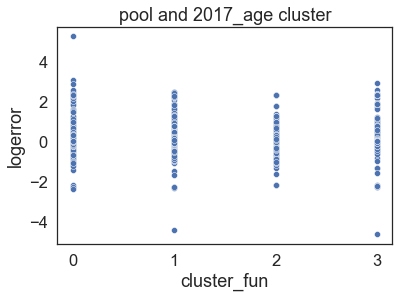

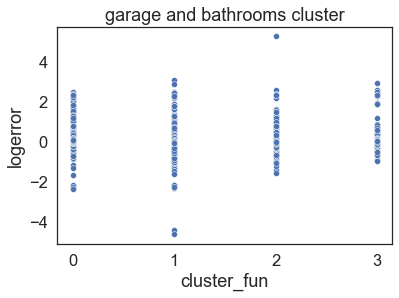

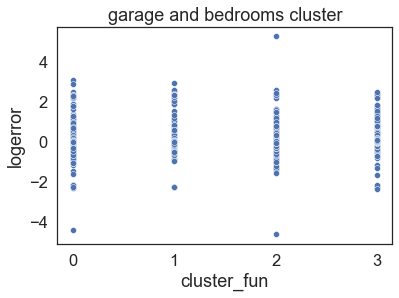

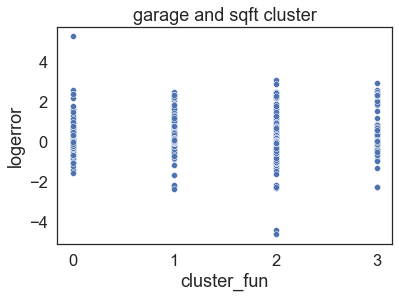

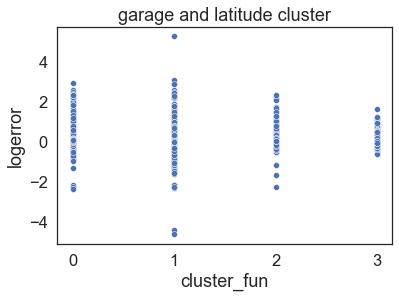

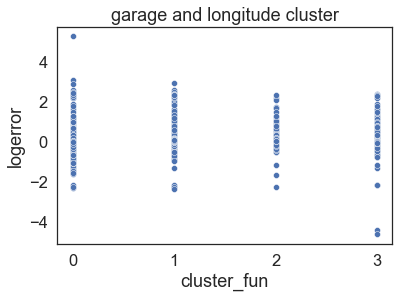

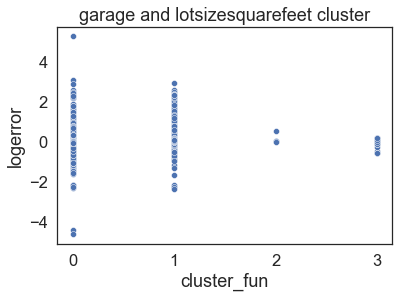

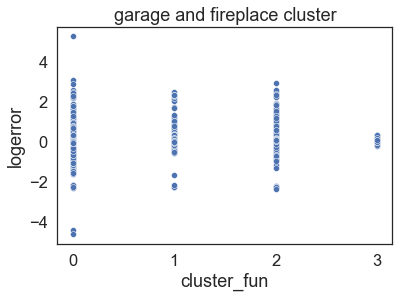

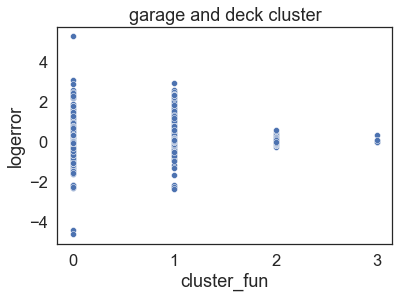

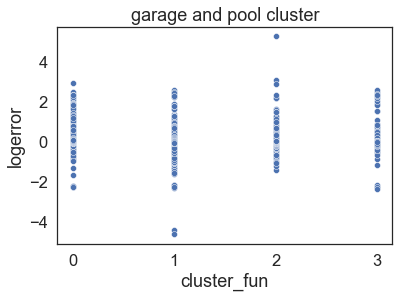

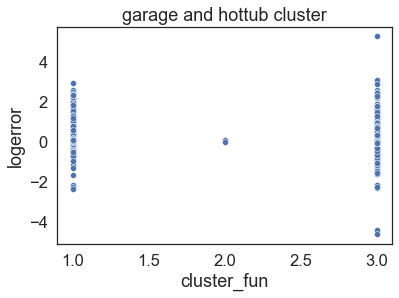

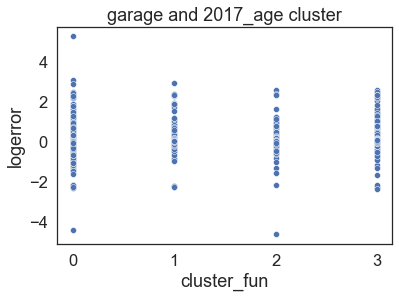

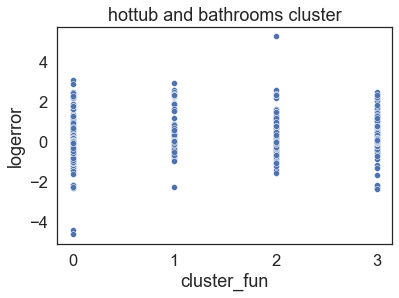

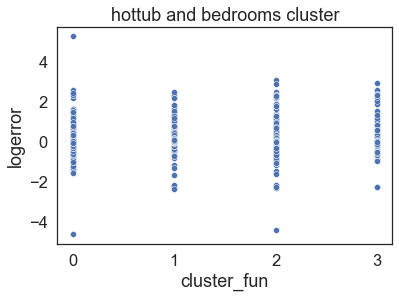

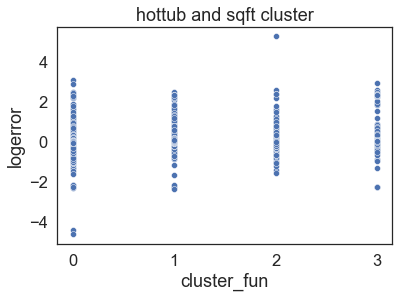

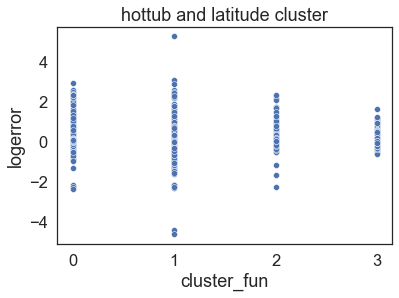

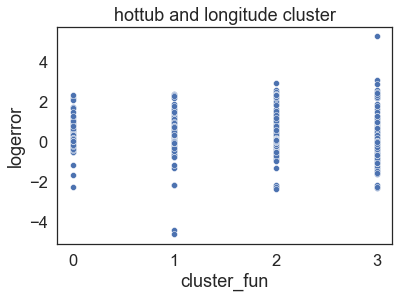

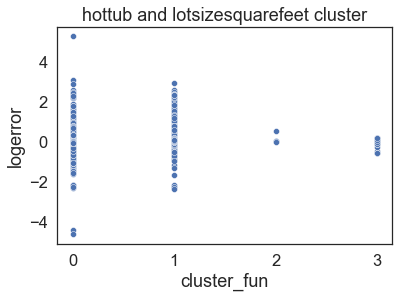

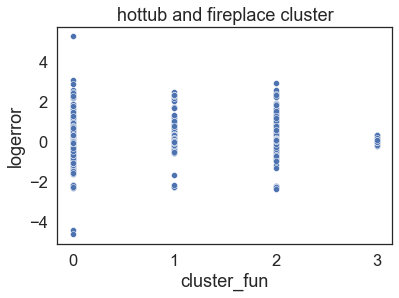

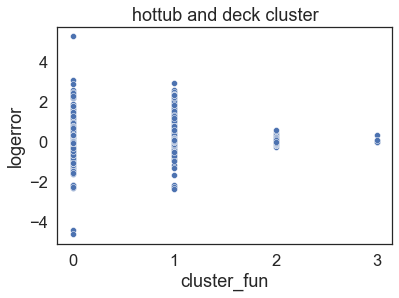

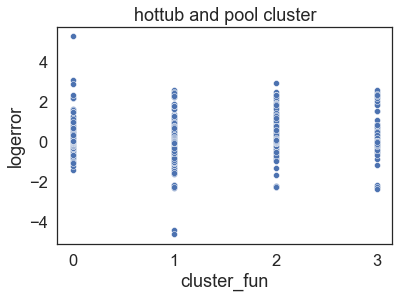

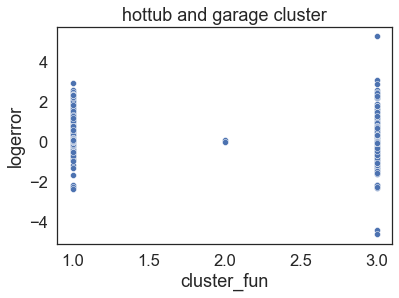

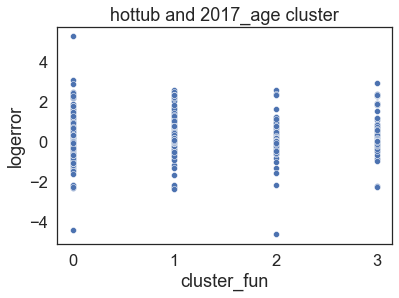

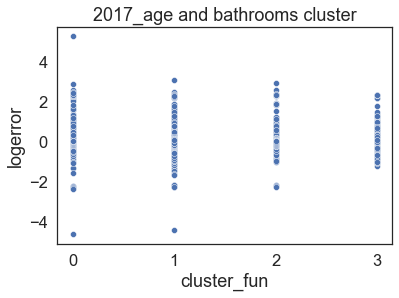

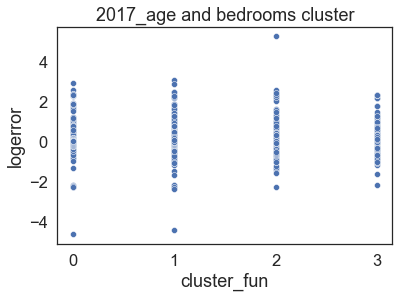

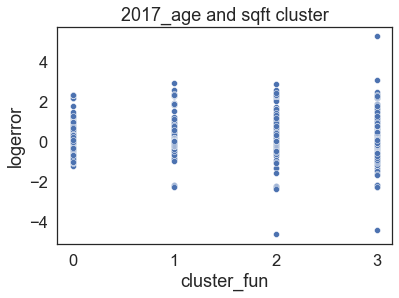

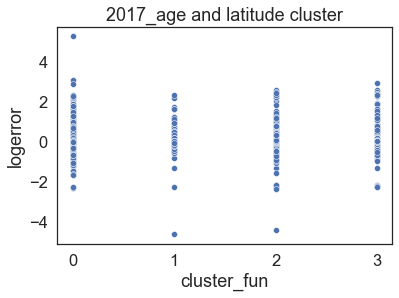

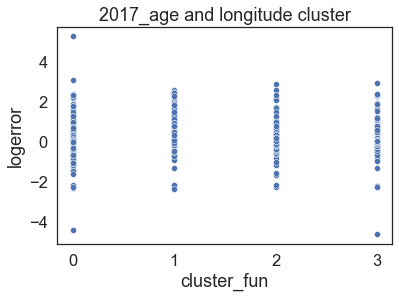

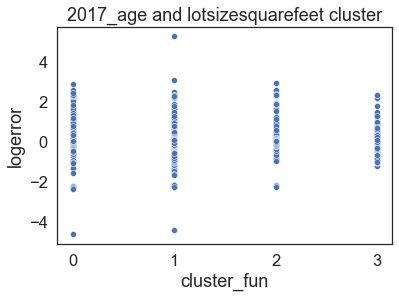

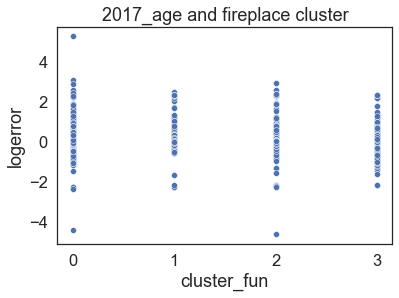

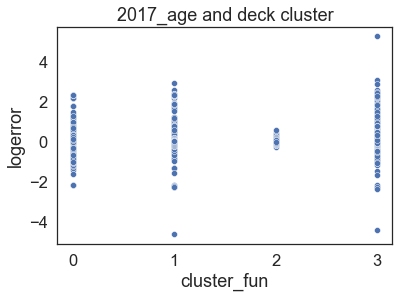

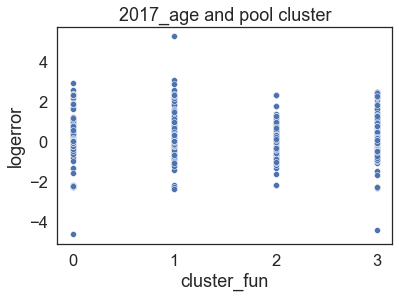

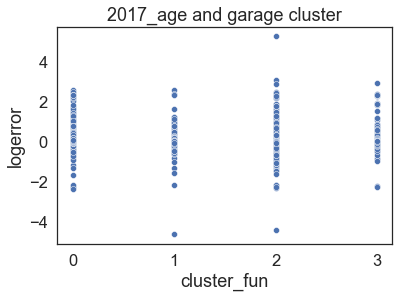

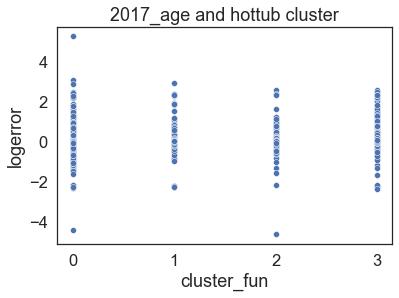

In [111]:
for feature in all_features:
    for feature2 in all_features:
        if feature != feature2: 
            cluster_fun = cluster_test[[feature, feature2]]

            #Fit a new model to my scaled data
            kmeans_scale = KMeans(n_clusters=4)

            kmeans_scale.fit(cluster_fun)

            cluster_test['cluster_fun'] = kmeans_scale.predict(cluster_fun)
            plt.title(f'{feature} and {feature2} cluster')
            sns.scatterplot(y='logerror', x='cluster_fun',
                    palette='colorblind', data=cluster_test)
            plt.show()

In [89]:
train.deck.value_counts()

0    33445
1      252
Name: deck, dtype: int64

## cluster options

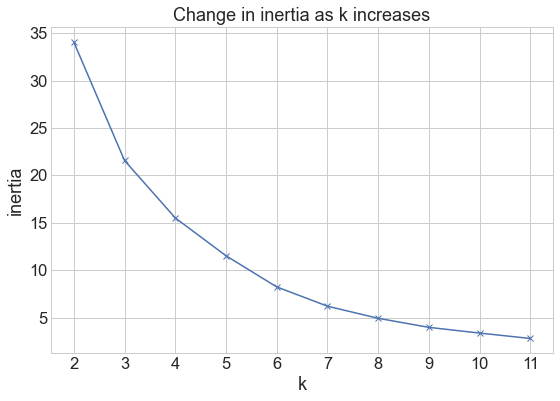

In [31]:
from sklearn.cluster import KMeans
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(sqft_lotsize_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [32]:
#Fit a new model to my scaled data
kmeans_scale = KMeans(n_clusters=5)

kmeans_scale.fit(sqft_lotsize_cluster)

train_scale['sqft_lotsize_cluster'] = kmeans_scale.predict(sqft_lotsize_feature)

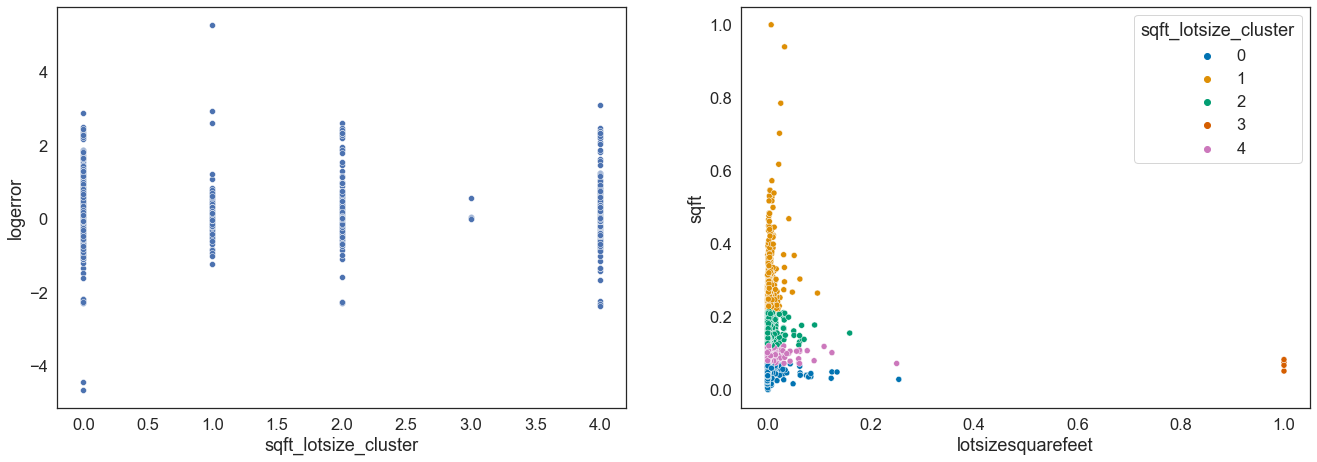

In [33]:
sns.set(font_scale=1.5)
sns.set_style('white')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
fig.tight_layout(pad=4.0)

sns.scatterplot(ax=ax1, y='logerror', x='sqft_lotsize_cluster',
                palette='colorblind', data=train_scale)
sns.scatterplot(ax=ax2, y='sqft', x='lotsizesquarefeet', hue='sqft_lotsize_cluster',
                palette='colorblind', data=train_scale)

plt.show()

# Modeling

### Prep for modeling
* I scaled the drivers using the minmax scaler
* Split the data into where ```home_value``` is the target variable

In [15]:
#prepare data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = w.prep_for_model(train, validate, test, 'logerror', drivers)

### Baseline models
* Looked at both using mean and median as a baseline model.
* Mean baseline performed better on the in-sample and out-of sample data SO I went with mean.

In [18]:
import sklearn.metrics as metric

def baseline_models(y_train, y_validate):
    '''
    Takes in y_train and y_validate and returns a df of 
    baseline_mean and baseline_median and how they perform
    '''
    train_predictions = pd.DataFrame(y_train)
    validate_predictions = pd.DataFrame(y_validate)
    
    y_pred_mean = y_train.mean()
    train_predictions['y_pred_mean'] = y_pred_mean
    validate_predictions['y_pred_mean'] = y_pred_mean
    
    y_pred_median = y_train.median()
    train_predictions['y_pred_median'] = y_pred_median
    validate_predictions['y_pred_median'] = y_pred_median

    # create the metric_df as a blank dataframe
    metric_df = pd.DataFrame(data=[
    {
        'model': 'mean_baseline', 
        'RMSE_train': metric.mean_squared_error(
            y_train,
            train_predictions['y_pred_mean']) ** .5,
        'RMSE_validate': metric.mean_squared_error(
            y_validate,
            validate_predictions['y_pred_mean']) ** .5,
        'Difference': (( metric.mean_squared_error(
            y_train,
            train_predictions['y_pred_mean']) ** .5)-(metric.mean_squared_error(
            y_validate,
            validate_predictions['y_pred_mean']) ** .5))
    }])

    return metric_df.append(
            {
                'model': 'median_baseline', 
                'RMSE_train': metric.mean_squared_error(
                    y_train,
                    train_predictions['y_pred_median']) ** .5,
                'RMSE_validate': metric.mean_squared_error(
                    y_validate,
                    validate_predictions['y_pred_median']) ** .5,
                'Difference': (( metric.mean_squared_error(
                    y_train,
                    train_predictions['y_pred_median']) ** .5)-(metric.mean_squared_error(
                    y_validate,
                    validate_predictions['y_pred_median']) ** .5))
            }, ignore_index=True)

In [19]:
baseline_models(y_train, y_validate)

model  RMSE_train  RMSE_validate  Difference
0    mean_baseline    0.174556        0.18238   -0.007824
1  median_baseline    0.174886        0.18275   -0.007864

### Model Comparison

In [ ]:
#run and compare models
#m.regression_models(X_train, y_train, X_validate, y_validate)

### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* It was interesting that OLS Regressor and Lasso Lars both performed better on the out-of-sample data.

### Best model: Random Forest Model 
* I chose the XXX (XXXXXXXXXX) because the difference in $RMSE$ between the train and validate was around  and they were both higher than the other models
* I will now run the that model on test data to gauge how it will perform on future data

In [ ]:
#m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

## Conclusion

### Summary
*


### Recommendations
* We should do more research .
* .

### Next Steps
* In the next iteration:
    * 